# Rolling Planning mit Flowtime Verfahren

In [1]:
import json
import pandas as pd
pd.set_option('display.max_rows', 40)

# Basics
import utils.basics.presenter as show
import utils.basics.converter as convert

import utils.checker as check
from ProductionDaySimulation import ProductionDaySimulation

In [2]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced

In [3]:
import utils.schedule_solver__arrival as ssv_a
import utils.reschedule.schedule_solver__arrival as rssv_a

## Generierung des Datensatzes für 6 Tage (Ankunft)

In [4]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)

df_jssp, df_times = rp_init.init_jobs_with_arrivals(df_instance, 8,  u_b_mmax = 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
1515,Job_151,5,M9,76
1516,Job_151,6,M5,47
1517,Job_151,7,M3,52
1518,Job_151,8,M4,90


In [5]:
df_times

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
147,Job_147,11270.89
148,Job_148,11277.28
149,Job_149,11278.72
150,Job_150,11404.04


In [6]:
solver_limit = 60*75 # je 75 min
solver_limit

4500

In [7]:
def get_schedule_filename(day: int, suffix: str = "", prefix: str = "06") -> str:
    file_template = "data/{prefix}_schedule_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return file_template.format(prefix=prefix,day=day, suffix=suffix)


## Params

In [8]:
# fix
day_length = 1440
horizon_days = 3

file_template = "data/06_schedule_{day:02d}.csv"

In [9]:
day_numb = 0
planning_end = 0

# Initialisierung (Tag 0)

In [10]:
day_numb = 0

In [11]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 4320

In [12]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
565,Job_056,5,M9,76
566,Job_056,6,M5,47
567,Job_056,7,M3,52
568,Job_056,8,M4,90


In [13]:
df_times_curr 

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
52,Job_052,4070.89
53,Job_053,4077.28
54,Job_054,4078.72
55,Job_055,4204.04


### (zusätzliche Jobs)

In [14]:
"""

extra_job_prefix = 'A'

df_jssp_curr, df_times_curr = rp_init.add_extra_jobs_to_current_horizon(
    df_existing_jobs=df_jssp_curr,
    df_existing_arrivals=df_times_curr,
    df_template=df_jssp,
    start_time=day_start - 120,
    start_index=day_numb*10,
    job_prefix=extra_job_prefix,
    mean_interarrival_time=120,
    job_numb=1,
    shuffle=True
)
df_jssp_curr

"""

"\n\nextra_job_prefix = 'A'\n\ndf_jssp_curr, df_times_curr = rp_init.add_extra_jobs_to_current_horizon(\n    df_existing_jobs=df_jssp_curr,\n    df_existing_arrivals=df_times_curr,\n    df_template=df_jssp,\n    start_time=day_start - 120,\n    start_index=day_numb*10,\n    job_prefix=extra_job_prefix,\n    mean_interarrival_time=120,\n    job_numb=1,\n    shuffle=True\n)\ndf_jssp_curr\n\n"

### Jobs vorziehen

In [15]:
# Test
df_jssp_beforehand, df_times_beforehand = rp_init.sample_jobs_with_times_after_arrivaltime(df_jssp, df_times, 
                                                                             min_arrival_time=planning_end,
                                                                             n=2, random_state=123)
df_times_beforehand

,Job,Arrival
128,Job_128,9830.89
119,Job_119,8959.39


In [16]:
df_jssp_curr, df_times_curr = rp_init.add_beforehand_jobs_to_current_horizon(
    df_existing_jobs = df_jssp_curr,
    df_existing_times = df_times_curr,
    df_jssp = df_jssp,
    df_times = df_times,
    min_arrival_time = planning_end,
    n=3,
    random_state=23
)
df_times_curr

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
55,Job_055,4204.04
56,Job_056,4309.61
57,Job_086,6651.94
58,Job_150,11404.04


### Scheduling

In [17]:
df_plan = ssv_a.solve_jssp_weighted_individual_flowtime(df_jssp_curr, df_times_curr , solver_time_limit=solver_limit, threads = 8)
df_plan


Solver-Informationen:
  Zielfunktionswert       : 462.8052
  Solver-Status           : Optimal
  Anzahl Variablen        : 18360
  Anzahl Constraints      : 36060


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.0,29.00
1,Job_000,1,0.00,M1,29.00,78,107.0,107.00
2,Job_000,2,0.00,M2,107.00,9,116.0,116.00
3,Job_000,3,0.00,M3,116.00,36,152.0,152.00
4,Job_000,4,0.00,M4,152.00,49,201.0,201.00
...,...,...,...,...,...,...,...,...
595,Job_150,5,11404.04,M5,11605.04,11,212.0,11616.04
596,Job_150,6,11404.04,M6,11616.04,62,274.0,11678.04
597,Job_150,7,11404.04,M7,11678.04,56,330.0,11734.04
598,Job_150,8,11404.04,M8,11734.04,44,374.0,11778.04


In [18]:
df_plan.to_csv(get_schedule_filename(day=day_numb), index = False)

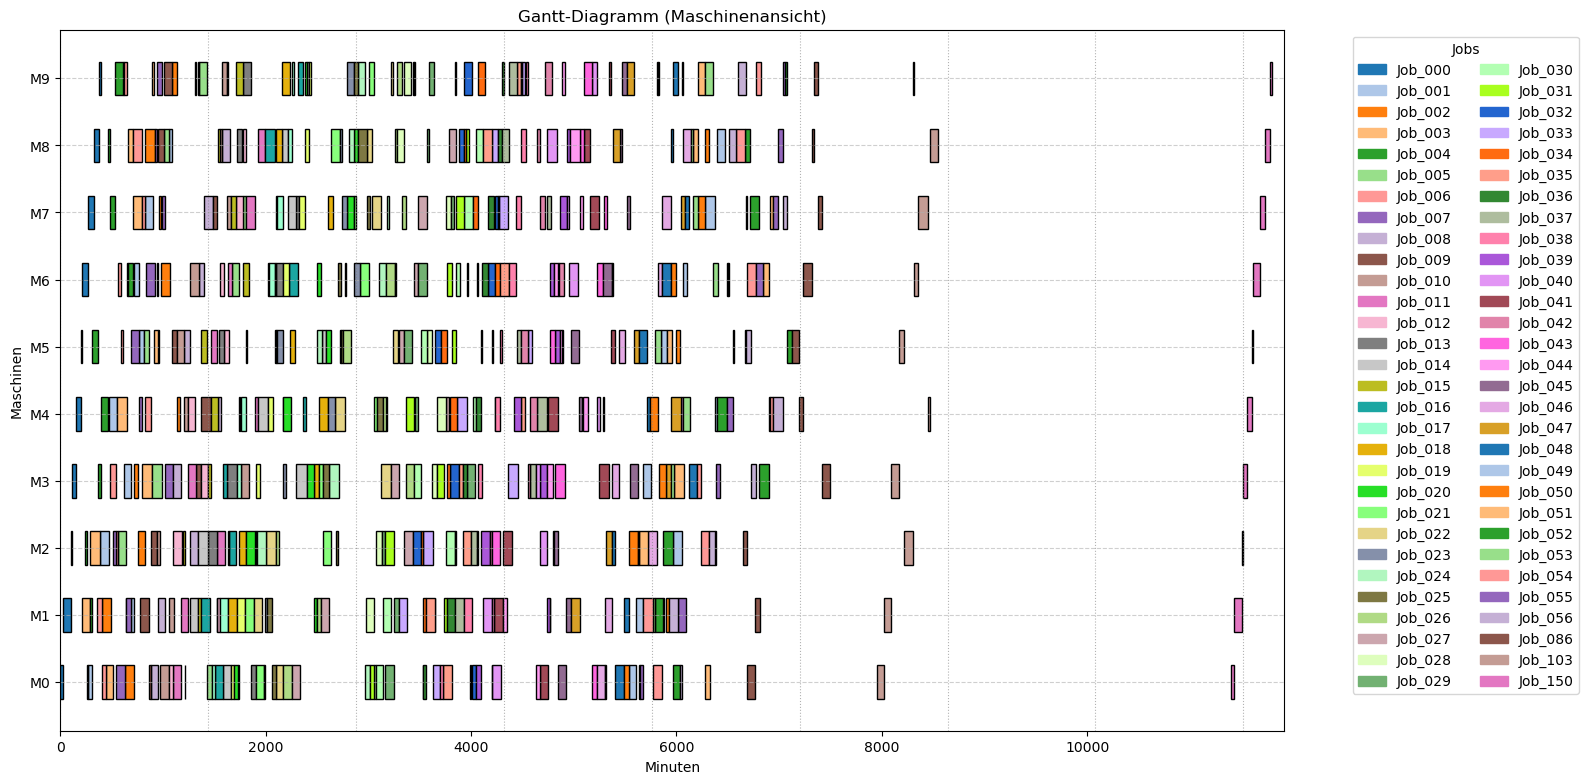

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [19]:
show.plot_gantt_machines(df_plan)
check.check_all_constraints(df_plan)

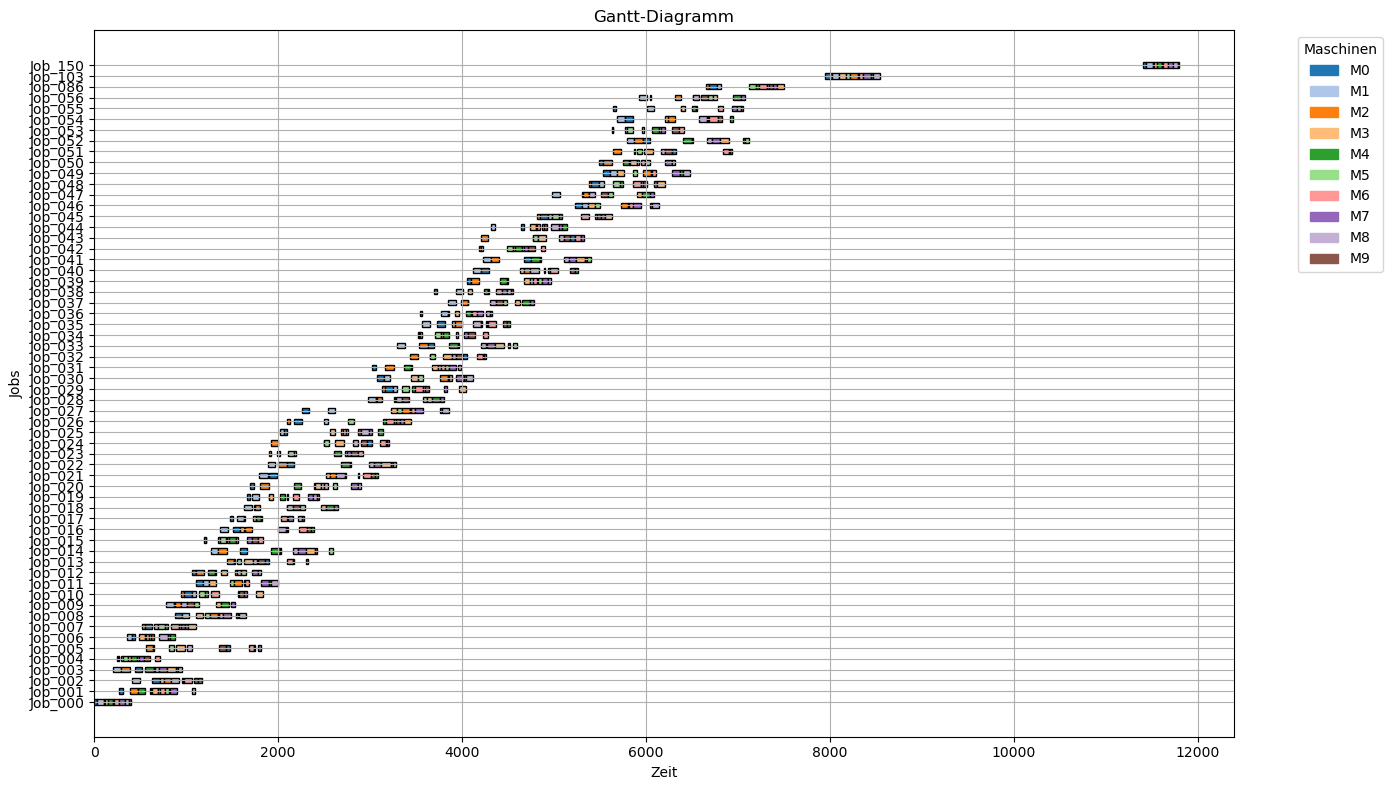

In [20]:
show.plot_gantt_jobs(df_plan)

### Simulation

In [21]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:34:55] Job_000 finished on M1 (after 65 minutes 56 seconds)
[01:47:00] Job_000 started on M2
[01:53:25] Job_000 finished on M2 (after 06 minutes 25 seconds)
[01:56:00] Job_000 started on M3
[02:45:29] Job_000 finished on M3 (after 49 minutes 29 seconds)
[02:45:29] Job_000 started on M4
[03:27:58] Job_003 started on M1
[03:58:22] Job_000 finished on M4 (after 72 minutes 53 seconds)
[03:58:22] Job_000 started on M5
[04:06:36] Job_004 started on M2
[04:07:56] Job_000 finished on M5 (after 09 minutes 34 seconds)
[04:07:56] Job_000 started on M6
[04:25:46] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:25:46] Job_004 started on M0
[04:30:44] Job_004 finished on M0 (after 04 minutes 58 seconds)
[04:30:44] Job_001 started on M0
[04:54:59] Job_003 finished on M1 (after 87 minutes 01 second)
[04:54:59] Job_004 started on M1
[04:54:59] Job_003 started on

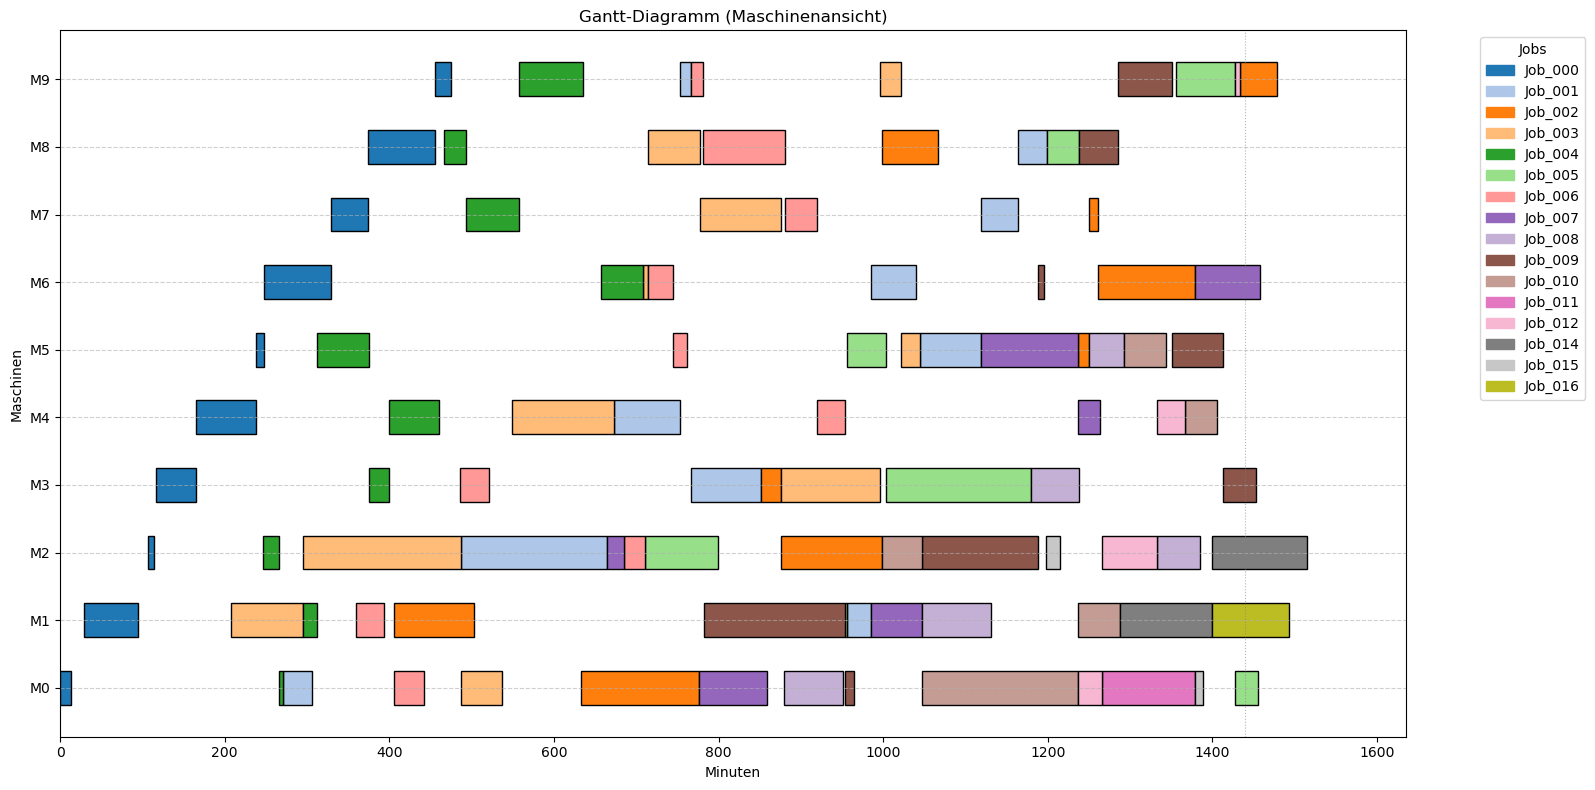

In [22]:
show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")

In [23]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
4,Job_007,6,515.63,M8,920.63,19
5,Job_007,7,515.63,M9,939.63,48
6,Job_007,8,515.63,M7,987.63,36
7,Job_007,9,515.63,M3,1023.63,79
0,Job_002,9,152.78,M4,1132.95,33
...,...,...,...,...,...,...
495,Job_150,5,11404.04,M5,11605.04,11
496,Job_150,6,11404.04,M6,11616.04,62
497,Job_150,7,11404.04,M7,11678.04,56
498,Job_150,8,11404.04,M8,11734.04,44


## Day 1

In [24]:
day_numb = 1

day_start = day_length*day_numb                      # 1440
day_end = day_start + day_length                     # 2880
planning_end =  day_start + horizon_days*day_length  # 5760

In [25]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
190,Job_019,0,M0,29
191,Job_019,1,M1,78
192,Job_019,2,M2,9
193,Job_019,3,M3,36
194,Job_019,4,M4,49
...,...,...,...,...
755,Job_075,5,M9,76
756,Job_075,6,M5,47
757,Job_075,7,M3,52
758,Job_075,8,M4,90


In [26]:
# evtl. nicht gestarte Operationen ergänzen
df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_007,6,M8,19
1,Job_007,7,M9,48
2,Job_007,8,M7,36
3,Job_007,9,M3,79
4,Job_002,9,M4,33
...,...,...,...,...
685,Job_075,5,M9,76
686,Job_075,6,M5,47
687,Job_075,7,M3,52
688,Job_075,8,M4,90


In [27]:
df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)
df_times_curr

,Job,Arrival
0,Job_002,152.78
1,Job_005,319.39
2,Job_007,515.63
3,Job_008,748.04
4,Job_009,781.95
...,...,...
69,Job_074,5644.04
70,Job_075,5749.61
71,Job_086,6651.94
72,Job_103,7948.04


In [28]:
# zusätzliche Jobs (vorzeitig)
df_jssp_curr, df_times_curr = rp_init.add_beforehand_jobs_to_current_horizon(
    df_existing_jobs = df_jssp_curr,
    df_existing_times = df_times_curr,
    df_jssp = df_jssp,
    df_times = df_times,
    min_arrival_time = planning_end,
    n=3,
    random_state=23
)
df_times_curr

,Job,Arrival
0,Job_002,152.78
1,Job_005,319.39
2,Job_007,515.63
3,Job_008,748.04
4,Job_009,781.95
...,...,...
72,Job_103,7948.04
73,Job_150,11404.04
74,Job_095,7200.00
75,Job_143,10971.94


In [29]:
# relevante Bedingungen aus der Simulation
df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
28,Job_002,8,152.78,M9,1433.72,44.24,1325.18,1477.96
55,Job_005,6,319.39,M0,1427.95,27.28,1135.84,1455.23
71,Job_007,5,515.63,M6,1378.31,79.20,941.88,1457.51
84,Job_009,7,781.95,M3,1413.02,39.61,670.68,1452.63
96,Job_014,1,1190.89,M2,1399.27,116.00,324.38,1515.27
99,Job_016,0,1198.72,M1,1399.27,93.62,294.17,1492.89


### Rescheduling

#### a) r = 0.8

In [30]:
this_r = 0.8 # 80 % Effizienz, 20 % Stabilität

In [31]:
df_reschedule = rssv_a.solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
    df_jssp = df_jssp_curr,
    df_arrivals = df_times_curr,
    df_executed=df_execution_important,
    df_original_plan=df_plan,
    r = this_r, 
    solver_time_limit = solver_limit,
    reschedule_start = day_start,
    threads = 8
)
df_reschedule


Solver-Informationen:
  Zielfunktionswert       : 46535.5816
  Solver-Status           : Optimal
  Anzahl Variablen        : 27318
  Anzahl Constraints      : 53839


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_002,9,152.78,M4,1542.63,33.0,1422.85,1575.63
1,Job_005,7,319.39,M6,1616.96,65.0,1362.57,1681.96
2,Job_005,8,319.39,M4,1685.27,6.0,1371.88,1691.27
3,Job_005,9,319.39,M7,1706.96,25.0,1412.57,1731.96
4,Job_007,6,515.63,M8,1457.51,19.0,960.88,1476.51
...,...,...,...,...,...,...,...,...
715,Job_150,5,11404.04,M5,11605.04,11.0,212.00,11616.04
716,Job_150,6,11404.04,M6,11616.04,62.0,274.00,11678.04
717,Job_150,7,11404.04,M7,11678.04,56.0,330.00,11734.04
718,Job_150,8,11404.04,M8,11734.04,44.0,374.00,11778.04


In [32]:
df_reschedule.to_csv(get_schedule_filename(day=day_numb, suffix=f"r{this_r:.3f}"), index = False)

#### b) r = 0.2

In [33]:
this_r = 0.2 # 20 % Effizienz, 80 % Stabilität

df_reschedule = rssv_a.solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
    df_jssp = df_jssp_curr,
    df_arrivals = df_times_curr,
    df_executed=df_execution_important,
    df_original_plan=df_plan,
    r = this_r, 
    solver_time_limit = solver_limit,
    reschedule_start = day_start,
    threads = 8
)
df_reschedule


Solver-Informationen:
  Zielfunktionswert       : 250260.1113
  Solver-Status           : Optimal
  Anzahl Variablen        : 27318
  Anzahl Constraints      : 53839


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_002,9,152.78,M4,1548.63,33.0,1428.85,1581.63
1,Job_005,7,319.39,M6,1457.51,65.0,1203.12,1522.51
2,Job_005,8,319.39,M4,1542.63,6.0,1229.24,1548.63
3,Job_005,9,319.39,M7,1572.96,25.0,1278.57,1597.96
4,Job_007,6,515.63,M8,1457.51,19.0,960.88,1476.51
...,...,...,...,...,...,...,...,...
715,Job_150,5,11404.04,M5,11605.04,11.0,212.00,11616.04
716,Job_150,6,11404.04,M6,11616.04,62.0,274.00,11678.04
717,Job_150,7,11404.04,M7,11678.04,56.0,330.00,11734.04
718,Job_150,8,11404.04,M8,11734.04,44.0,374.00,11778.04


In [34]:
df_reschedule.to_csv(get_schedule_filename(day=day_numb, suffix=f"r{this_r:.3f}"), index = False)

#### c) r = 0.4

In [35]:
this_r = 0.4

df_reschedule = rssv_a.solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
    df_jssp = df_jssp_curr,
    df_arrivals = df_times_curr,
    df_executed=df_execution_important,
    df_original_plan=df_plan,
    r = this_r, 
    solver_time_limit = solver_limit,
    reschedule_start = day_start,
    threads = 8
)
df_reschedule


Solver-Informationen:
  Zielfunktionswert       : 140610.5191
  Solver-Status           : Optimal
  Anzahl Variablen        : 27318
  Anzahl Constraints      : 53839


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_002,9,152.78,M4,1548.63,33.0,1428.85,1581.63
1,Job_005,7,319.39,M6,1457.51,65.0,1203.12,1522.51
2,Job_005,8,319.39,M4,1542.63,6.0,1229.24,1548.63
3,Job_005,9,319.39,M7,1739.51,25.0,1445.12,1764.51
4,Job_007,6,515.63,M8,1457.51,19.0,960.88,1476.51
...,...,...,...,...,...,...,...,...
715,Job_150,5,11404.04,M5,11605.04,11.0,212.00,11616.04
716,Job_150,6,11404.04,M6,11616.04,62.0,274.00,11678.04
717,Job_150,7,11404.04,M7,11678.04,56.0,330.00,11734.04
718,Job_150,8,11404.04,M8,11734.04,44.0,374.00,11778.04


In [36]:
df_reschedule.to_csv(get_schedule_filename(day=day_numb, suffix=f"r{this_r:.3f}"), index = False)

In [37]:
df_plan = df_reschedule

### Simulation

In [38]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:12:37] Job_009 started on M4
[24:12:37] Job_012 started on M3
[24:17:30] Job_005 started on M6
[24:17:30] Job_007 started on M8
[24:29:15] Job_007 finished on M8 (after 11 minutes 45 seconds)
[24:34:57] Job_017 started on M0
[24:37:57] Job_008 started on M9
[24:44:04] Job_008 finished on M9 (after 06 minutes 07 seconds)
[24:48:57] Job_007 started on M9
[24:52:53] Job_015 started on M1
[24:59:26] Job_005 finished on M6 (after 41 minutes 56 seconds)
[25:01:06] Job_017 finished on M0 (after 26 minutes 10 seconds)
[25:03:57] Job_016 started on M0
[25:15:16] Job_013 started on M2
[25:17:42] Job_015 finished on M1 (after 24 minutes 49 seconds)
[25:17:42] Job_017 started on M1
[25:17:42] Job_015 started on M5
[25:22:30] Job_010 started on M6
[25:41:08] Job_009 finished on M4 (after 88 minutes 31 seconds)
[25:42:37] Job_005 started on M4
[25:49:01] Job_005 finished on M4 (after 06 minutes 23 seconds)
[25:49:01] Job_002 started on M4
[26:01:33] Job_007 finished on M9 (after 72 minutes 36 se

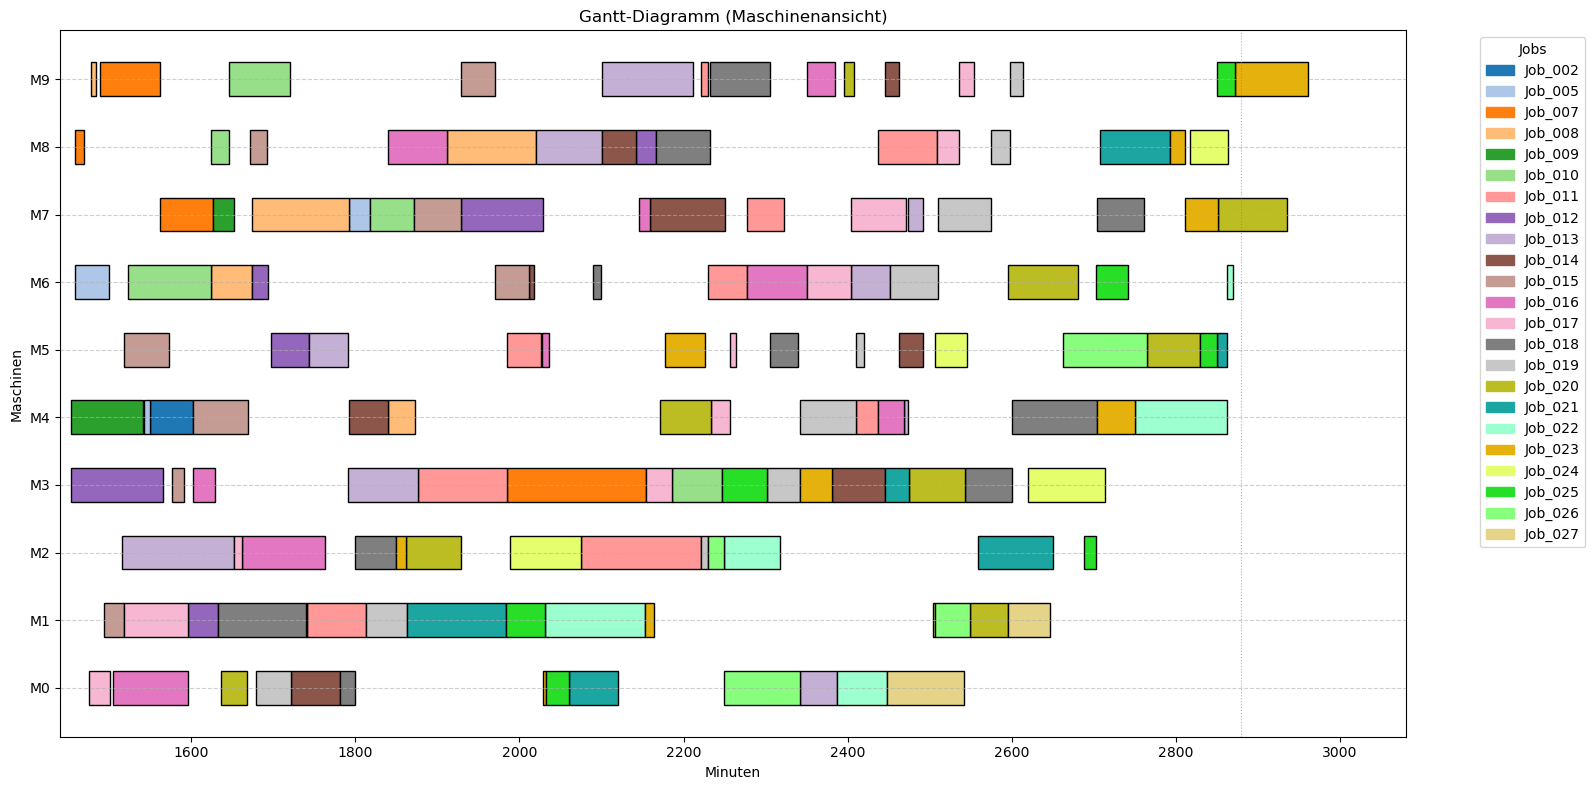

In [39]:
show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")

In [40]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
10,Job_023,9,1686.61,M6,2861.95,53.0
0,Job_020,9,1528.05,M8,2864.95,30.0
1,Job_021,6,1592.78,M7,2864.95,12.0
11,Job_024,5,1759.39,M9,2896.95,72.0
16,Job_025,7,1799.74,M8,2896.95,89.0
...,...,...,...,...,...,...
559,Job_143,6,10971.94,M8,11778.04,19.0
572,Job_150,9,11404.04,M9,11778.04,21.0
560,Job_143,7,10971.94,M9,11799.04,48.0
561,Job_143,8,10971.94,M7,11847.04,36.0


## Day 2-5


Solver-Informationen:
  Zielfunktionswert       : 166570.8524
  Solver-Status           : Optimal
  Anzahl Variablen        : 31884
  Anzahl Constraints      : 62902


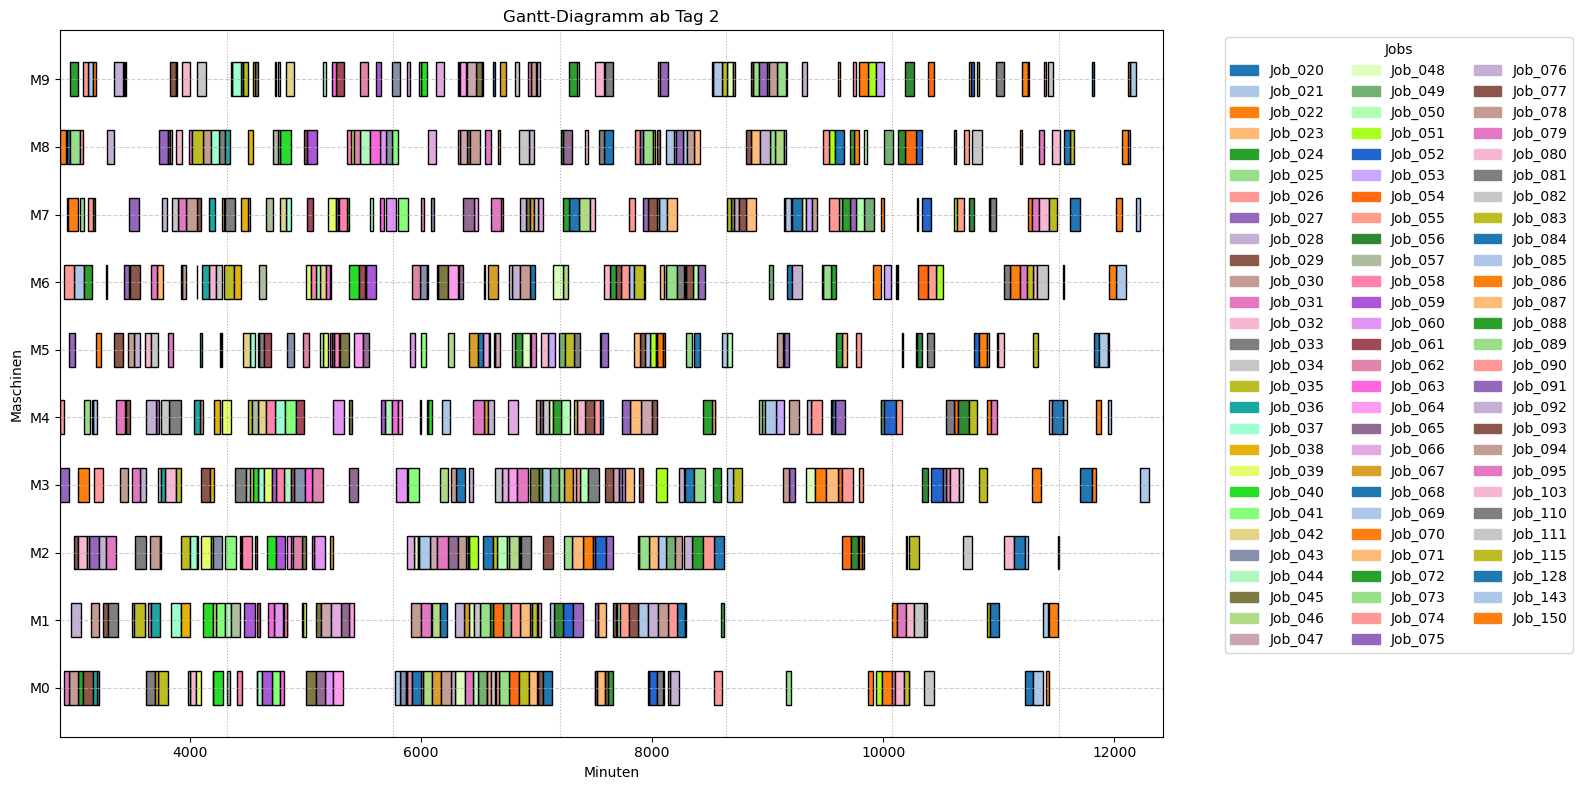

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.

[48:00:00] Job_022 started on M8
[48:00:00] Job_026 started on M4
[48:00:00] Job_027 started on M3
[48:33:54] Job_031 started on M0
[48:40:20] Job_026 finished on M4 (after 40 minutes 20 seconds)
[48:40:20] Job_026 started on M6
[48:51:44] Job_022 finished on M8 (after 51 minutes 44 seconds)
[48:56:13] Job_020 started on M8
[48:56:13] Job_021 started on M7
[49:08:36] Job_021 finished on M7 (after 12 minutes 23 seconds)
[49:08:36] Job_022 started on M7
[49:20:11] Job_020 finished on M8 (after 23 minutes 58 seconds)
[49:20:54] Job_024 started on M9
[49:26:13] Job_025 started on M8
[49:31:00] Job_031 finished on M0 (after 57 minutes 06 seconds)
[49:31:00] Job_030 started on M0
[49:33:56] Job_028 started on M1
[49:41:54] Job_027 finished on M3 (after 101 minutes 55 secon

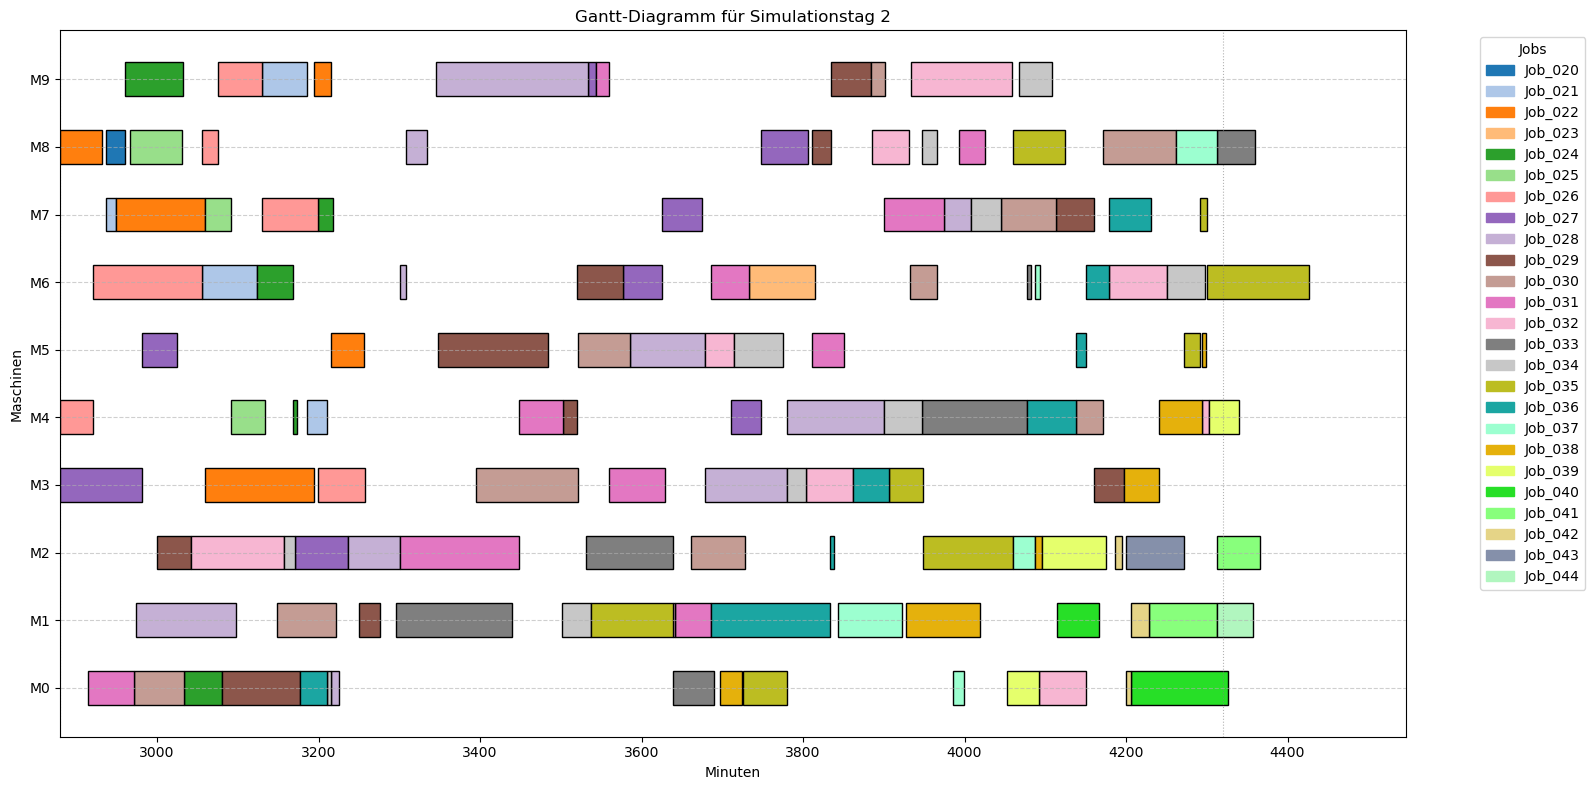


Solver-Informationen:
  Zielfunktionswert       : 301766.7576
  Solver-Status           : Optimal
  Anzahl Variablen        : 35792
  Anzahl Constraints      : 70670


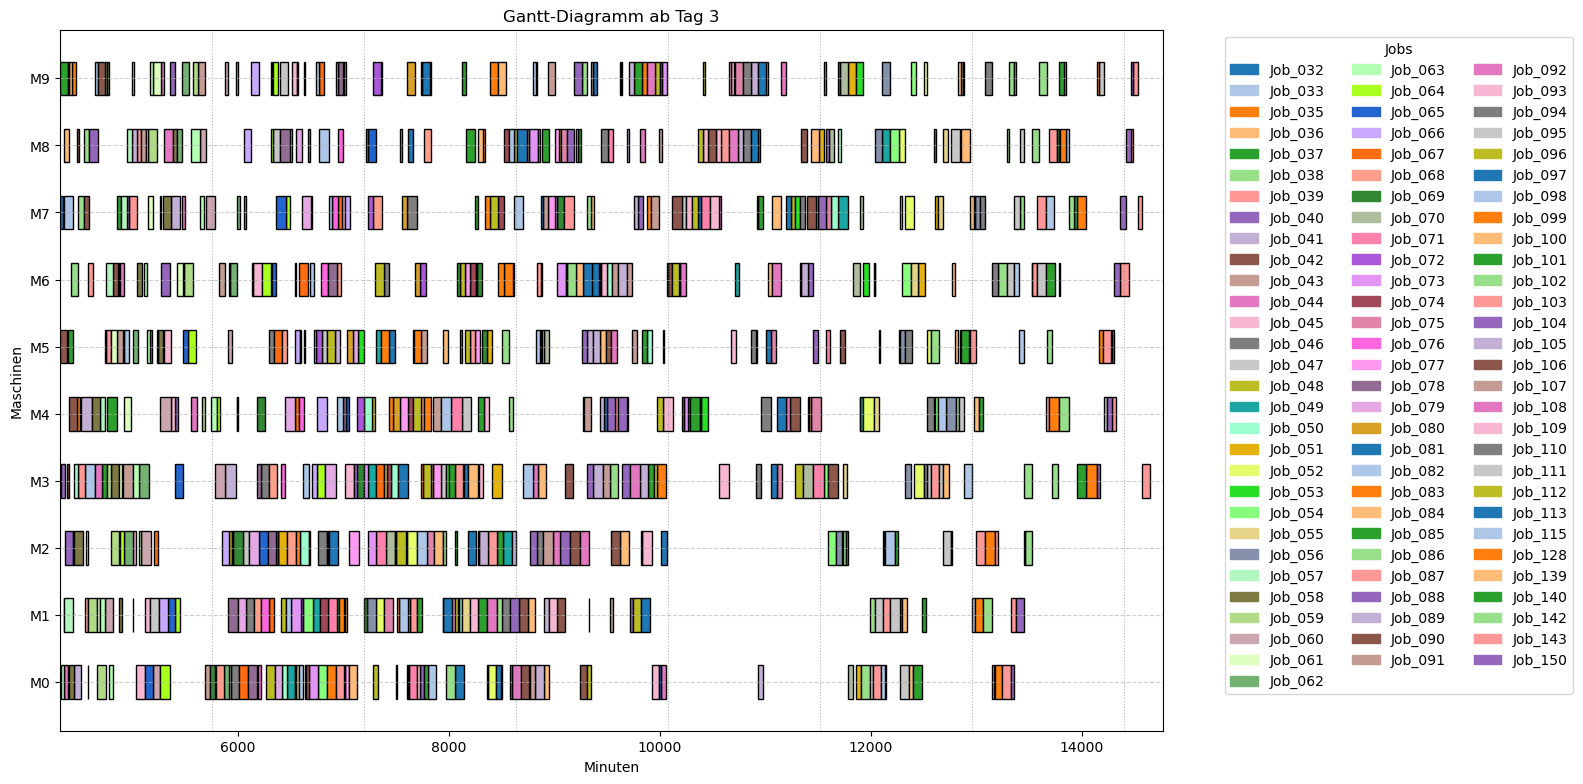

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.

[72:00:00] Job_032 started on M7
[72:00:00] Job_037 started on M9
[72:00:00] Job_042 started on M5
[72:05:43] Job_040 started on M3
[72:05:43] Job_057 started on M0
[72:29:03] Job_032 finished on M7 (after 29 minutes 03 seconds)
[72:33:39] Job_057 finished on M0 (after 27 minutes 56 seconds)
[72:37:03] Job_043 started on M1
[72:37:03] Job_044 started on M0
[72:38:53] Job_043 finished on M1 (after 01 minute 50 seconds)
[72:39:03] Job_057 started on M1
[72:39:52] Job_033 started on M7
[72:39:52] Job_036 started on M8
[72:57:49] Job_040 finished on M3 (after 52 minutes 07 seconds)
[72:57:49] Job_040 started on M2
[73:17:49] Job_044 finished on M0 (after 40 minutes 46 seconds)
[73:28:03] Job_058 started on M0
[73:28:15] Job_036 finished on M8 (after 48 minutes 23 seconds

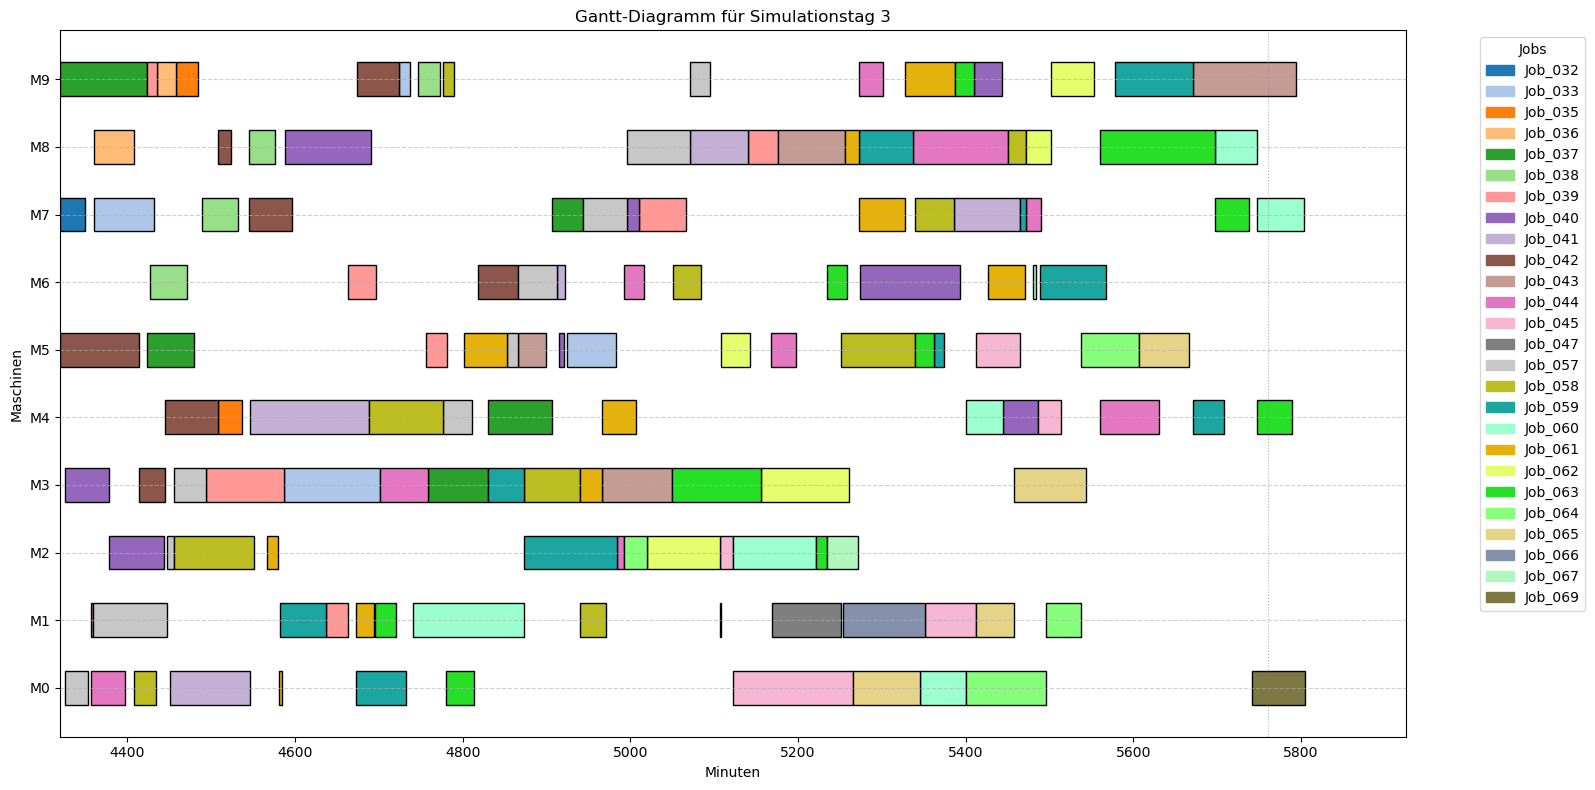


Solver-Informationen:
  Zielfunktionswert       : 419016.7466
  Solver-Status           : Optimal
  Anzahl Variablen        : 40944
  Anzahl Constraints      : 80908


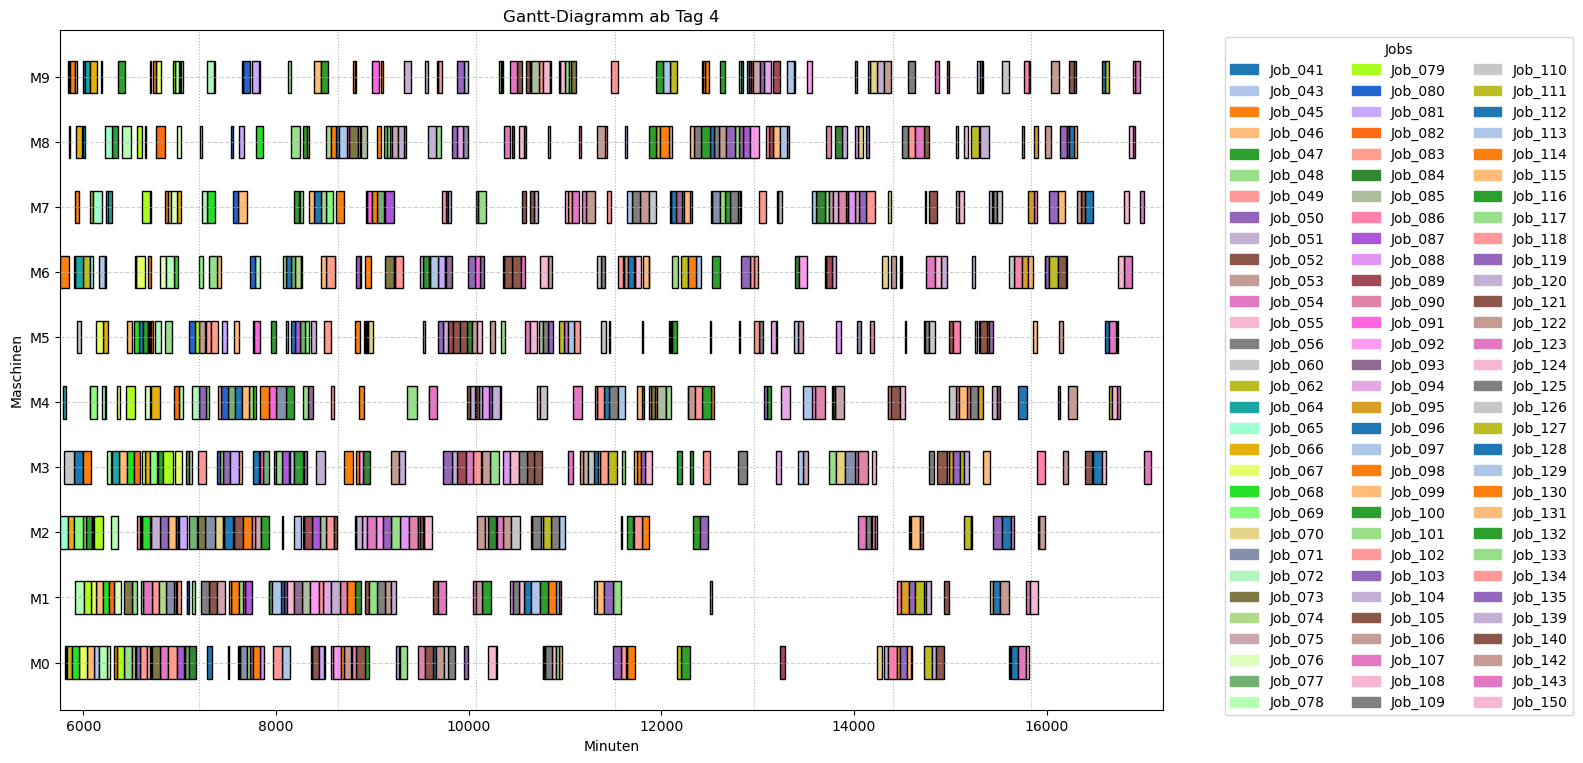

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.

[96:00:00] Job_045 started on M6
[96:00:00] Job_065 started on M2
[96:29:09] Job_064 started on M4
[96:42:52] Job_060 started on M3
[96:45:10] Job_066 started on M0
[96:50:55] Job_064 finished on M4 (after 21 minutes 46 seconds)
[97:09:36] Job_066 finished on M0 (after 24 minutes 26 seconds)
[97:09:36] Job_047 started on M0
[97:12:10] Job_065 finished on M2 (after 72 minutes 10 seconds)
[97:22:43] Job_047 finished on M0 (after 13 minutes 08 seconds)
[97:22:43] Job_062 started on M0
[97:25:00] Job_066 started on M2
[97:25:00] Job_065 started on M9
[97:28:02] Job_045 finished on M6 (after 88 minutes 02 seconds)
[97:28:02] Job_045 started on M8
[97:46:56] Job_045 finished on M8 (after 18 minutes 55 seconds)
[97:47:04] Job_065 finished on M9 (after 22 minutes 05 seconds)

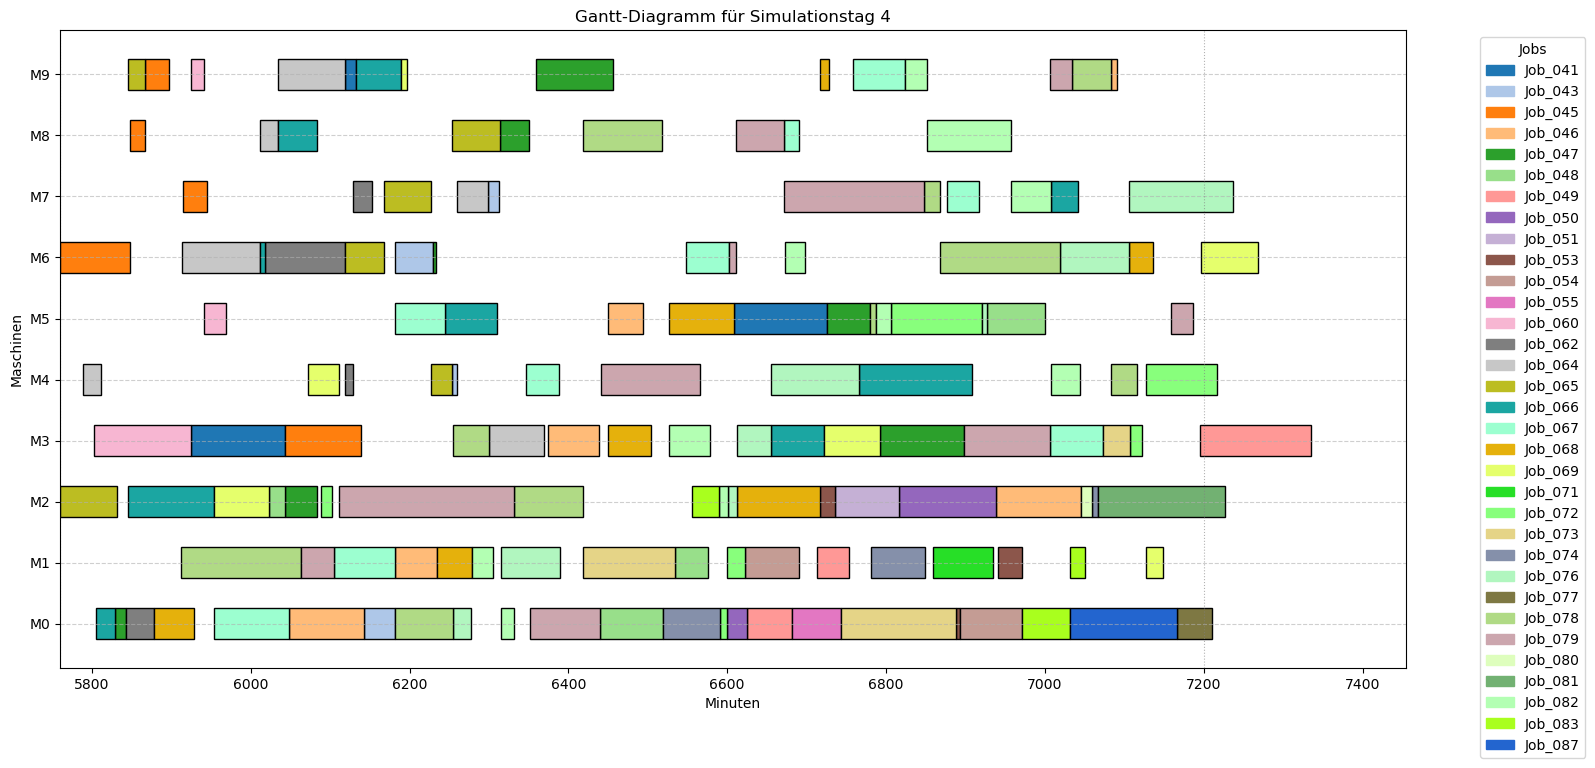

/Users/konrad_adamski/Coding/HTWD_JSSP/02_Mai/utils/rolling_planning/init_jobs_times.py:275: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined_times = pd.concat([df_existing_times, df_sampled_times], ignore_index=True)



Solver-Informationen:
  Zielfunktionswert       : 200199.8342
  Solver-Status           : Optimal
  Anzahl Variablen        : 37865
  Anzahl Constraints      : 74790


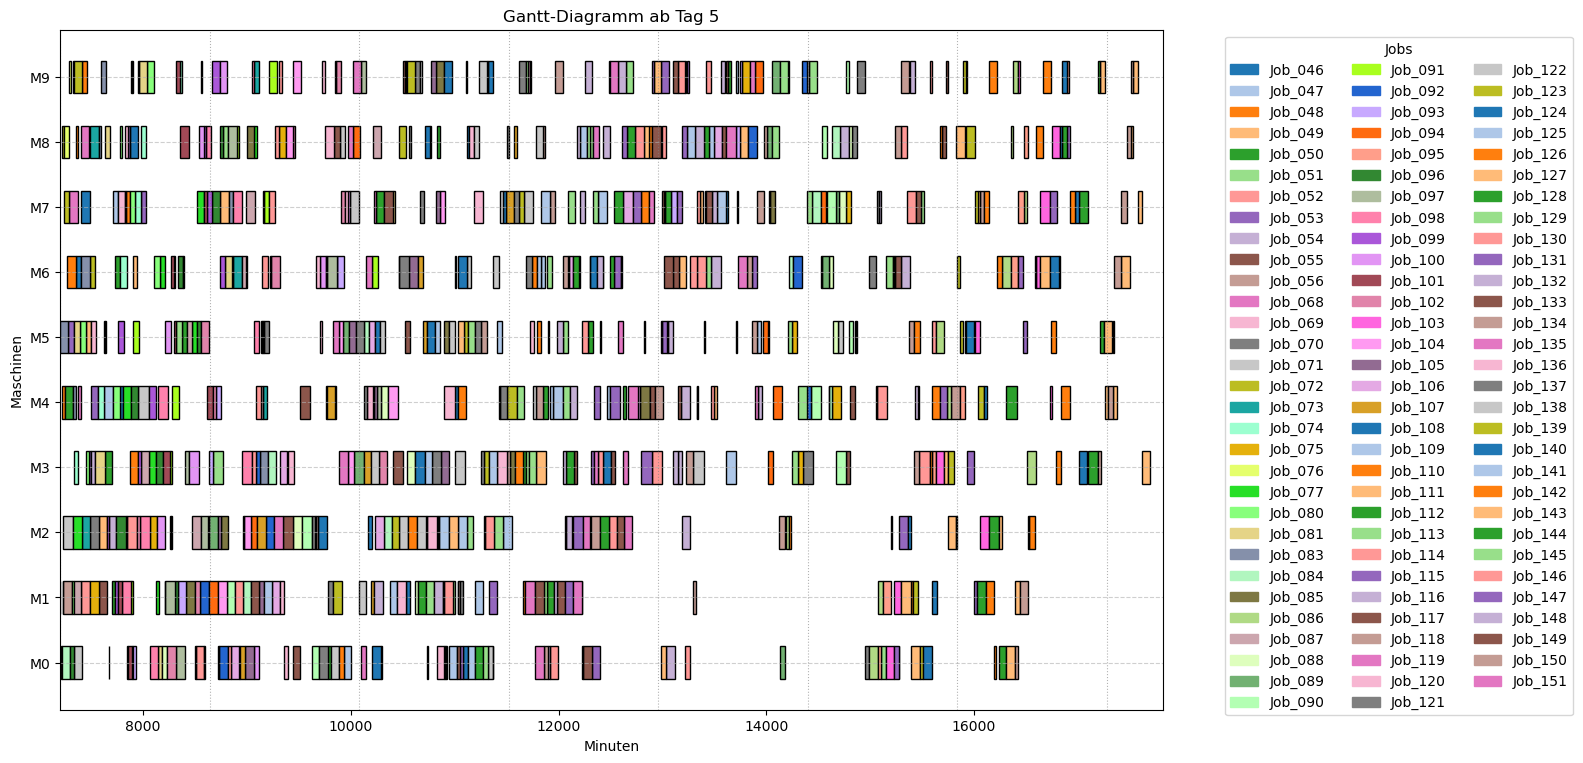

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.

[120:00:00] Job_051 started on M1
[120:00:00] Job_083 started on M5
[120:01:52] Job_051 finished on M1 (after 01 minute 53 seconds)
[120:10:43] Job_080 started on M0
[120:15:25] Job_080 finished on M0 (after 04 minutes 43 seconds)
[120:16:22] Job_048 started on M4
[120:16:22] Job_072 started on M8
[120:16:43] Job_084 started on M0
[120:26:21] Job_071 started on M2
[120:26:21] Job_081 started on M1
[120:28:45] Job_081 finished on M1 (after 02 minutes 24 seconds)
[120:28:45] Job_056 started on M1
[120:40:23] Job_048 finished on M4 (after 24 minutes 02 seconds)
[120:46:48] Job_072 finished on M8 (after 30 minutes 26 seconds)
[120:46:48] Job_076 started on M8
[120:46:48] Job_072 started on M7
[120:48:22] Job_050 started on M4
[121:07:57] Job_048 started on M6
[121:18:29]

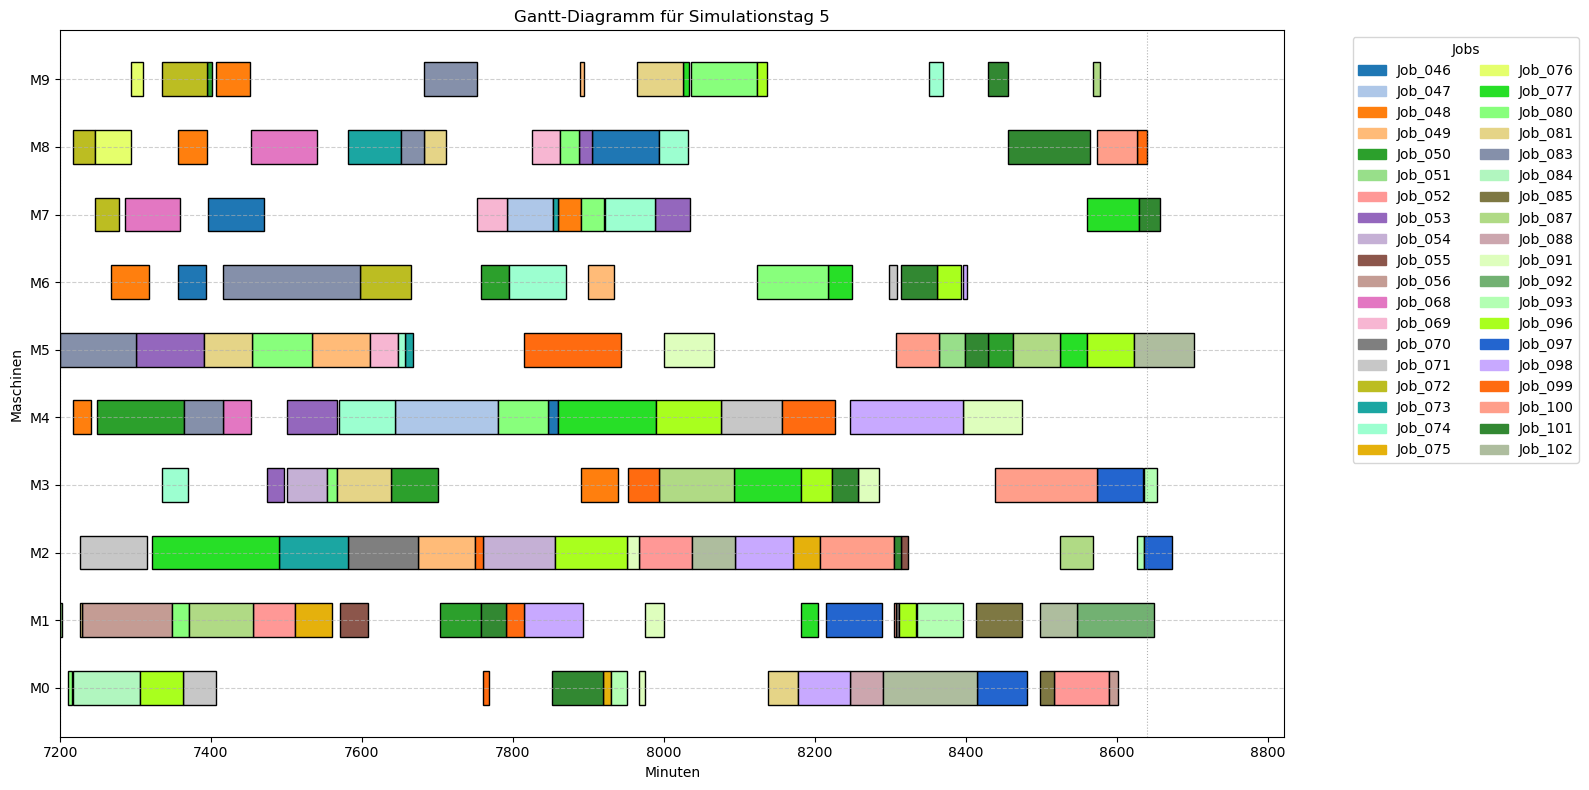

In [41]:
last_planning_start = 5

for day_numb in range(2, last_planning_start + 1):  # Schleife von 2 bis 5
    day_start = day_length*day_numb                     
    day_end = day_start + day_length                 
    planning_end =  day_start + horizon_days*day_length
    
    # Ia aktuelles Ankunftszeitfenster
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)

    # Ib Operation ergänzen, die zuvor bekannt und nicht abgeschlossen (aber evtl. nicht aktuellen Zeitfenster) 
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)

    # Ic Zeiten-Dataframe aktualisieren (wegen Ib)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)


    # II drei zusätzliche Jobs (vorzeitig)
    df_jssp_curr, df_times_curr = rp_init.add_beforehand_jobs_to_current_horizon(
        df_existing_jobs = df_jssp_curr,
        df_existing_times = df_times_curr,
        df_jssp = df_jssp,
        df_times = df_times,
        min_arrival_time = planning_end,
        n=3,
        random_state=23
    )

    # III relevante Bedingungen aus der Simulation (Operationen, die in aktuellen Planunghorizont hineinlaufen)
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # Rescheduling
    this_r = 0.4   # 40 % Effizienz, 60 % Stabilität

    df_plan = rssv_a.solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
        df_jssp = df_jssp_curr,
        df_arrivals = df_times_curr,
        df_executed=df_execution_important,
        df_original_plan=df_plan,
        r = this_r, 
        solver_time_limit = solver_limit,
        reschedule_start = day_start,
        threads = 8
    )
    df_plan.to_csv(get_schedule_filename(day=day_numb), index = False)

    show.plot_gantt_machines(df_plan, title = f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_all_constraints(df_plan)

    # Simulation (ein Tag)
    simulation = ProductionDaySimulation(df_plan, vc=0.35)
    df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)
    show.plot_gantt_machines(df_execution, 
                             title = f"Gantt-Diagramm für Simulationstag {day_numb}",
                             duration_column = "Simulated Processing Time")